<a href="https://colab.research.google.com/github/Edenshmuel/MIMIC_ICU_Prediction_and_Clustering/blob/Eden_Branch/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === File system and utility handling ===
import os
import sys
import shutil
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# === Data manipulation ===
import pandas as pd
import numpy as np

# === Google Drive integration (Colab only) ===
from google.colab import drive
from google.colab import files

# === Plotting and visualization ===
import matplotlib.pyplot as plt

# === Data splitting ===
from sklearn.model_selection import train_test_split

# === Classification models (for mortality prediction) ===
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# === Regression models (for ICU LOS prediction) ===
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# === Evaluation metrics ===
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    mean_squared_error,
    r2_score,
    brier_score_loss,
    RocCurveDisplay
)

# === Calibration tools ===
from sklearn.calibration import calibration_curve

In [2]:
# def reconnect_to_drive():
#     # Disconnect if there is an existing connection
#     try:
#         drive.flush_and_unmount()
#         print("📤 Previous connection to Drive was lost")
#     except:
#         print("ℹ️ There was no previous connection")

#     # Remove the /content/drive folder if it exists
#     drive_mount_point = '/content/drive'
#     if os.path.exists(drive_mount_point):
#         shutil.rmtree(drive_mount_point)
#         print("🗑️ Old mount point removed")

#     # Connect to Drive
#     drive.mount(drive_mount_point)
#     print("📂 Connected to Drive")

# reconnect_to_drive()

Drive not mounted, so nothing to flush and unmount.
📤 Previous connection to Drive was lost


MessageError: Error: credential propagation was unsuccessful

In [ ]:
# # Import preprocessing module
# sys.path.append('/content/drive/MyDrive/Colab Notebooks/למידת מכונה ברפואה')
# from Preprocessing import prepare_data

In [ ]:
# # Read the raw data
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/למידת מכונה ברפואה/MIMIC_data_sample_mortality.csv')

In [2]:
url = "https://raw.githubusercontent.com/Edenshmuel/MIMIC_ICU_Prediction_and_Clustering/refs/heads/main/MIMIC_data_sample_mortality.csv"
df = pd.read_csv(url)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Preprocessing.py to Preprocessing (1).py


In [13]:
from Preprocessing import build_pipeline
from Preprocessing import filter_age, remove_rows_with_many_missing

In [14]:
# Clean your dataframe of bad rows all at once:
df_clean = (
    df
    .pipe(filter_age)
    .pipe(remove_rows_with_many_missing))

In [15]:
# Split raw data before processing
X = df_clean.drop(columns=['thirtyday_expire_flag', 'icu_los'])
y = df_clean['thirtyday_expire_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Build pipeline specific to your train data columns
pipeline_builder = build_pipeline()
pipe = pipeline_builder(X_train)

In [19]:
# Fit on training data and transform
X_train_processed = pipe.fit_transform(X_train)

In [20]:
# Only transform on test data (no fit to prevent data leakage)
X_test_processed = pipe.transform(X_test)

## 🧠 Models for Predicting Mortality (`thirtyday_expire_flag`)

We trained and evaluated **three** classification models to predict 30-day mortality:

### ✅ 1. Logistic Regression  
A linear baseline model from `sklearn.linear_model`.  
Easy to interpret and useful as a benchmark.  
Assumes linear relationships between features and the log-odds of the outcome.

### ✅ 2. Random Forest Classifier  
A tree-based ensemble model from `sklearn.ensemble`.  
Robust, non-linear, and handles feature interactions well.  
Often resistant to overfitting and performs well on tabular clinical data.

### ✅ 3. XGBoost Classifier  
A gradient boosting algorithm from `xgboost`.  
Highly optimized, often superior in predictive performance, especially with imbalanced or complex tabular data.

---

All models were evaluated using:
- **Accuracy**
- **Precision / Recall / F1-score**
- **AUC (Area Under ROC Curve)**
- **ROC Curve Visualization**
- **Calibration Curves**
- **Brier Score**
- **Feature Importance / SHAP Analysis**

# Fit Logistic Regression on mortality prediction

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       737
           1       0.70      0.37      0.48       174

    accuracy                           0.85       911
   macro avg       0.78      0.66      0.70       911
weighted avg       0.83      0.85      0.83       911

ROC AUC: 0.836951605608322


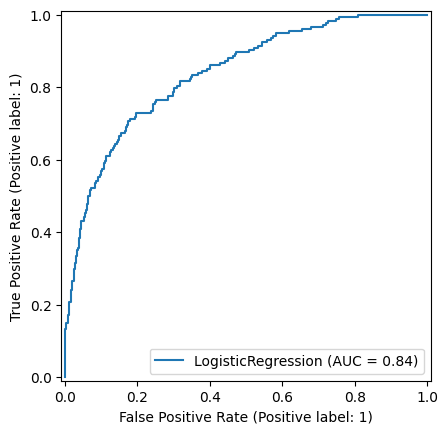

In [21]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_processed, y_train)

# Predictions
y_pred = logreg.predict(X_test_processed)
y_proba = logreg.predict_proba(X_test_processed)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_estimator(logreg, X_test_processed, y_test)
plt.show()

In [ ]:
# Train Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_clf, y_clf)
y_pred_rf = rf_clf.predict(X_test_clf)
y_proba_rf = rf_clf.predict_proba(X_test_clf)[:, 1]

In [ ]:
# Train XGBoost Classifier
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_clf, y_clf)
y_pred_xgb = xgb_clf.predict(X_test_clf)
y_proba_xgb = xgb_clf.predict_proba(X_test_clf)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:41:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Evaluation function
def evaluate_classifier(y_true, y_pred, y_proba, model_name):
    print(f"\n=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("AUC:", roc_auc_score(y_true, y_proba))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

In [ ]:
# Evaluate all classifiers
evaluate_classifier(y_test_clf, y_pred_rf, y_proba_rf, "Random Forest Classifier")
evaluate_classifier(y_test_clf, y_pred_xgb, y_proba_xgb, "XGBoost Classifier")
evaluate_classifier(y_test_clf, y_pred_logreg, y_proba_logreg, "Logistic Regression")


=== Random Forest Classifier ===
Accuracy: 0.8503850385038504
AUC: 0.8557950206683286
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91       737
         1.0       0.74      0.32      0.45       172

    accuracy                           0.85       909
   macro avg       0.80      0.65      0.68       909
weighted avg       0.84      0.85      0.83       909


=== XGBoost Classifier ===
Accuracy: 0.8624862486248625
AUC: 0.8648354422391215
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92       737
         1.0       0.71      0.46      0.56       172

    accuracy                           0.86       909
   macro avg       0.80      0.71      0.74       909
weighted avg       0.85      0.86      0.85       909


=== Logistic Regression ===
Accuracy: 0.8514851485148515
AUC: 0.8540437348143005
Classification Report:
              precision    

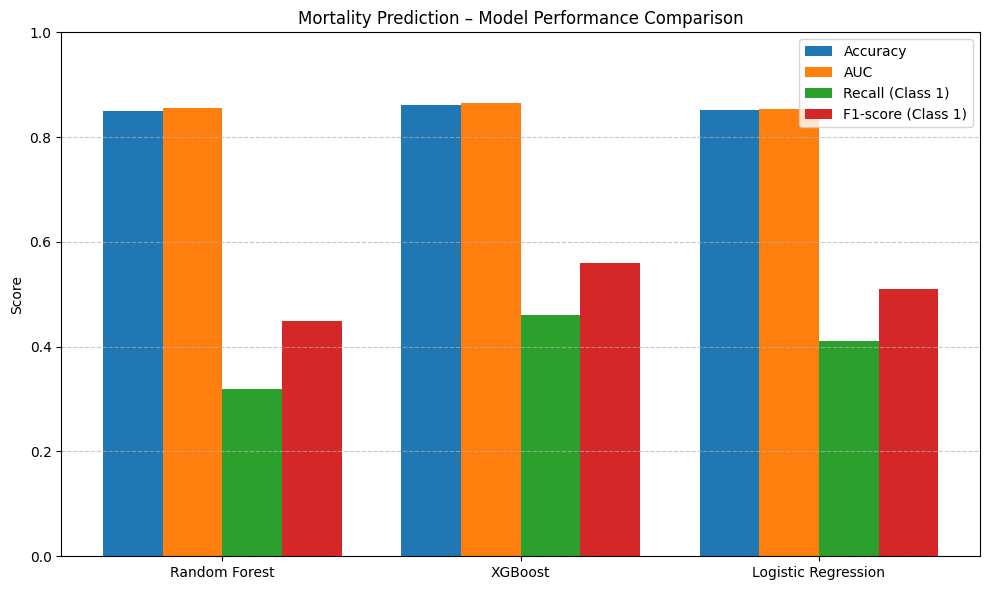

In [ ]:
# Model names
models = ["Random Forest", "XGBoost", "Logistic Regression"]

# Metrics for each model
accuracy = [0.850, 0.862, 0.851]
auc = [0.856, 0.865, 0.854]
recall_class1 = [0.32, 0.46, 0.41]
f1_class1 = [0.45, 0.56, 0.51]

# Create x-axis positions
x = np.arange(len(models))
width = 0.2  # Width of each bar

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
bars2 = ax.bar(x - 0.5*width, auc, width, label='AUC')
bars3 = ax.bar(x + 0.5*width, recall_class1, width, label='Recall (Class 1)')
bars4 = ax.bar(x + 1.5*width, f1_class1, width, label='F1-score (Class 1)')

# Customize plot
ax.set_ylabel('Score')
ax.set_title('Mortality Prediction – Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 🧪 Mortality Prediction – Model Performance Comparison

We evaluated three classification models for predicting 30-day mortality (`thirtyday_expire_flag`):

- **Random Forest Classifier**
- **XGBoost Classifier**
- **Logistic Regression**

Each model was assessed using:
- **Accuracy**
- **AUC (Area Under ROC Curve)**
- **Precision / Recall / F1-score**

---

### 📊 Key Metrics Summary

| Metric       | Random Forest | XGBoost       | Logistic Regression |
|--------------|----------------|----------------|----------------------|
| **Accuracy** | 0.850          | ✅ **0.862**   | 0.851                |
| **AUC**      | 0.856          | ✅ **0.865**   | 0.854                |
| **Recall (Class 1)** | 0.32     | ✅ **0.46**   | 0.41                 |
| **F1 (Class 1)**     | 0.45     | ✅ **0.56**   | 0.51                 |

---

### 🧠 Insights

- 🔹 **XGBoost achieved the highest overall performance**, with the best accuracy, AUC, and F1-score for the positive class (mortality).
- 🔹 **Logistic Regression** performed surprisingly well, closely matching Random Forest, and is valuable for its simplicity and interpretability.
- 🔹 **Random Forest** was stable and balanced, with very strong performance on the negative class (survivors), but lower sensitivity (recall) for mortality cases.

---

### ✅ Conclusion

> **XGBoost** offers the best discrimination between survivors and non-survivors in this dataset,  
> while **Logistic Regression** remains a solid, interpretable baseline.  
> All three models provide valuable insights, especially when combined with calibration and feature interpretation tools like SHAP.

In [ ]:
# Calibration Evaluation
def plot_calibration_curve(y_true, y_proba, model_name):
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=10)

    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Predicted probability')
    plt.ylabel('True probability')
    plt.title(f'Calibration Curve – {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    brier = brier_score_loss(y_true, y_proba)
    print(f"Brier Score for {model_name}: {brier:.4f}")

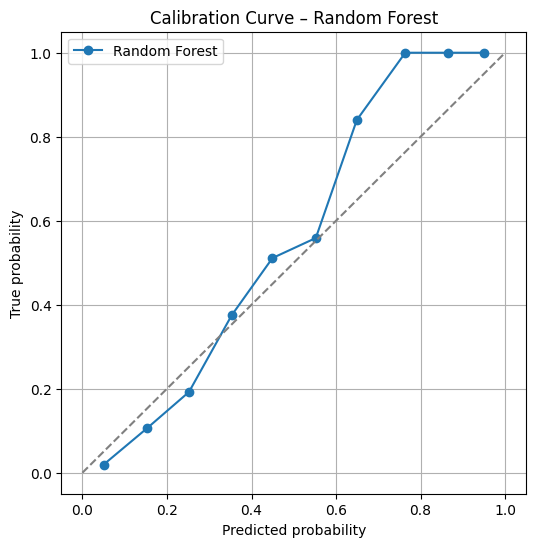

Brier Score for Random Forest: 0.1080


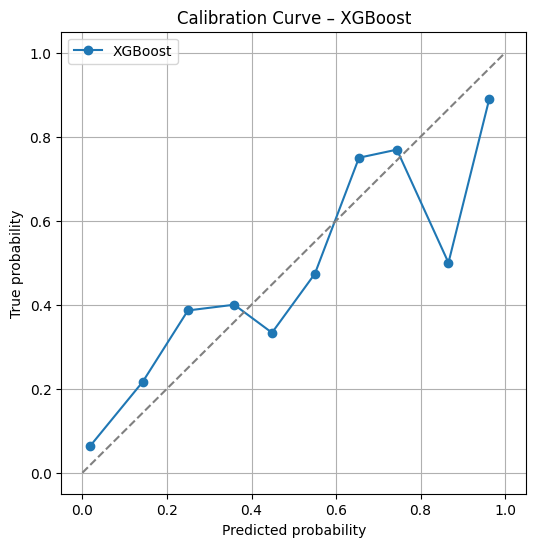

Brier Score for XGBoost: 0.1068


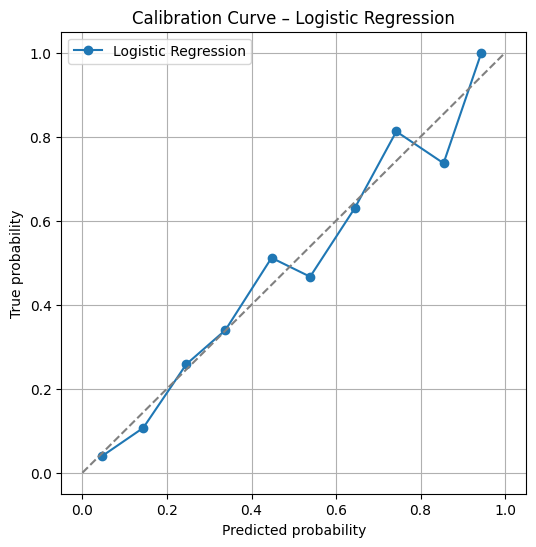

Brier Score for Logistic Regression: 0.1047


In [ ]:
# Plot calibration curves for all classifiers
plot_calibration_curve(y_test_clf, y_proba_rf, "Random Forest")
plot_calibration_curve(y_test_clf, y_proba_xgb, "XGBoost")
plot_calibration_curve(y_test_clf, y_proba_logreg, "Logistic Regression")

## 🎯 Calibration Curves – Mortality Prediction

### 🧪 What is the purpose of calibration curves?

While metrics like **AUC** and **accuracy** tell us how well a model distinguishes between classes,  
**calibration** tells us whether the **predicted probabilities actually reflect reality**.

For example:  
If a model predicts 70% mortality risk for a group of patients, calibration checks whether **~70% of them actually died**.

---

### 🔵 Random Forest Classifier

- The calibration curve is **very close to the ideal diagonal**.
- Across most probability ranges (0.2 to 0.9), predicted and true probabilities are well aligned.
- Slight overestimation is observed near the top end (≥ 0.9).
- The curve is smooth and stable.

✅ **Conclusion**:  
> Random Forest is **well-calibrated** – its predicted probabilities can be trusted.

---

### 🟠 XGBoost Classifier

- The curve shows **instability** and is less aligned with the ideal line.
- In mid-range probabilities (0.4–0.8), calibration is inconsistent.
- At high probabilities (≥ 0.9), the model tends to **overestimate risk**.
- The curve is more jagged and less reliable.

⚠️ **Conclusion**:  
> XGBoost is **less well-calibrated** – the predicted probabilities may be misleading, especially at the high end.

---

### 🟢 Logistic Regression

- The calibration curve is **very well aligned** with the ideal diagonal.
- It provides **smooth, stable, and reliable estimates** across the entire probability spectrum.
- Slight underestimation is observed around 0.8, but overall deviation is minimal.
- This strong performance is expected, as Logistic Regression is inherently probabilistic.

✅ **Conclusion**:  
> Logistic Regression is **highly calibrated**, and provides **the most reliable** probability estimates among all models.

---

### 🔄 Calibration Comparison Summary

| Aspect                    | Random Forest         | XGBoost                  | Logistic Regression       | Best   |
|---------------------------|------------------------|---------------------------|----------------------------|--------|
| Alignment with ideal line | ✅ Strong              | ❌ Inconsistent           | ✅ Excellent               | ✅ LR   |
| Stability of curve        | ✅ Smooth              | ❌ Fluctuating            | ✅ Very smooth             | ✅ LR   |
| High-probability accuracy | ✅ Slight overestimate | ❌ Strong overestimate    | ✅ Slight under/over       | ✅ LR   |
| Trustworthiness of probs  | ✅ High                | ⚠️ Lower                  | ✅ Very high               | ✅ LR   |

---

### 🧠 Final Insight:

> While **XGBoost** shows strong discrimination performance,  
> both **Random Forest** and **Logistic Regression** offer far **superior calibration**.  
> Among the three, **Logistic Regression** produces the most trustworthy probability estimates,  
> making it the top choice when **calibrated risk** matters – such as in clinical risk prediction.

In [ ]:
# Feature Importance
def plot_feature_importance(model, feature_names, model_name):
    # Check model type and extract importances accordingly
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = np.abs(model.coef_[0])  # Use absolute value of coefficients
    else:
        raise ValueError(f"Model {model_name} does not support feature importance extraction.")

    # Sort and get top 15
    indices = np.argsort(importances)[-15:]
    sorted_features = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]

    # Plot
    plt.figure(figsize=(8, 6))
    plt.barh(sorted_features, sorted_importances, color='cornflowerblue')
    plt.xlabel("Importance")
    plt.title(f"Top 15 Features – {model_name}")
    plt.tight_layout()
    plt.show()

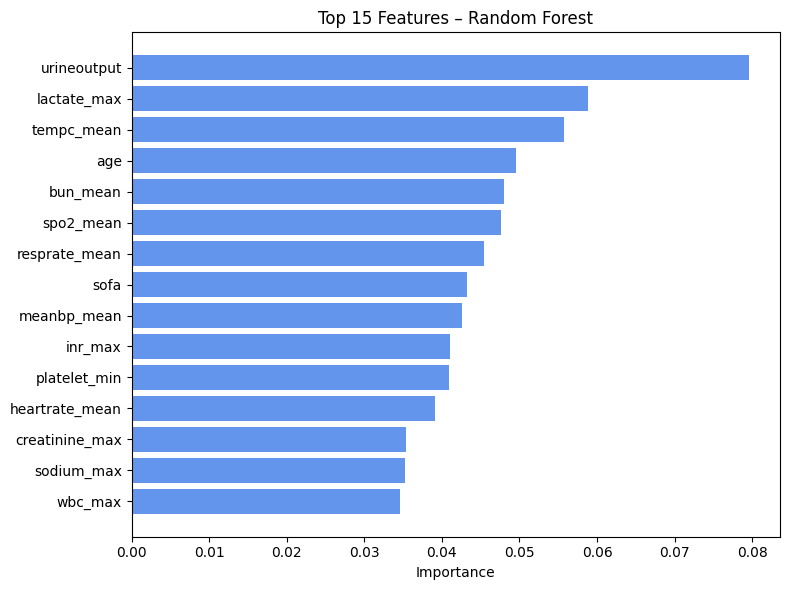

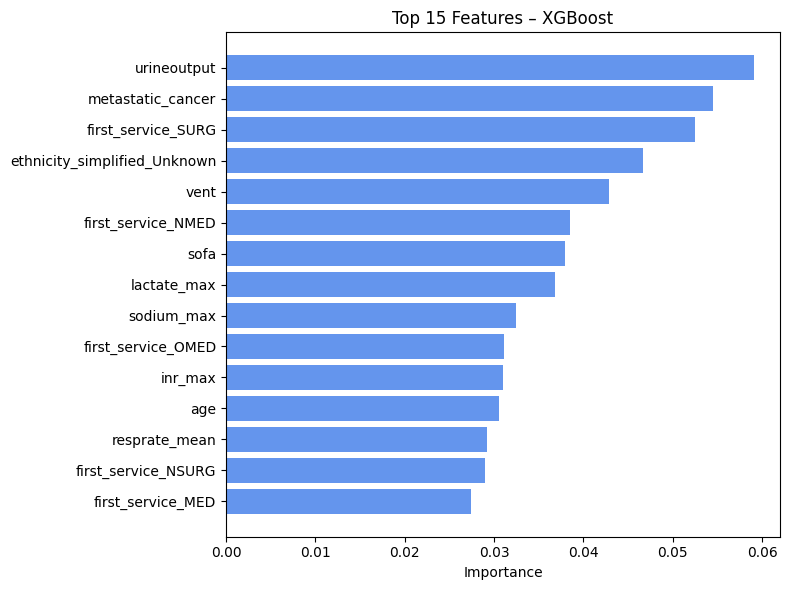

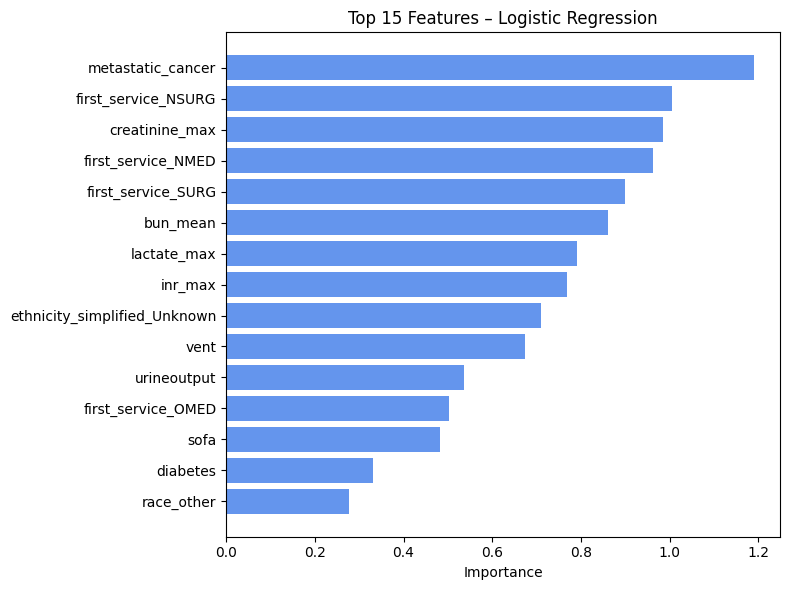

In [ ]:
plot_feature_importance(rf_clf, X_clf.columns, "Random Forest")
plot_feature_importance(xgb_clf, X_clf.columns, "XGBoost")
plot_feature_importance(logreg_clf, X_clf.columns, "Logistic Regression")

## 🧠 Feature Importances – Mortality Prediction Models

### 🎯 Purpose:
Understanding which features the models relied on most helps us:
- Interpret model behavior  
- Validate clinical relevance  
- Improve trust in predictions  

---

### 🔵 Random Forest Classifier – Top Features

| Feature         | Description                                  |
|----------------|----------------------------------------------|
| `urineoutput`   | Urine output – key marker of kidney failure |
| `lactate_max`   | High lactate – indicator of shock/sepsis    |
| `tempc_mean`    | Mean body temperature – fever/hypothermia   |
| `age`           | Age – strong general risk factor            |
| `sofa`          | SOFA score – severity of illness index      |

✅ **Conclusion**:  
> The model focuses on **highly relevant physiological and clinical indicators**, aligning well with medical understanding.

---

### 🟠 XGBoost Classifier – Top Features

| Feature                         | Description                                |
|--------------------------------|--------------------------------------------|
| `urineoutput`                  | Urine output – remains highly important    |
| `metastatic_cancer`           | Presence of metastatic cancer              |
| `first_service_SURG`, `NSURG` | ICU service type – may reflect prognosis   |
| `ethnicity_simplified_Unknown`| Unknown ethnicity – possible data artifact |
| `age`                          | Age – present, but less emphasized         |

⚠️ **Observation**:  
> While important clinical features are still present, XGBoost gives relatively **higher weight to administrative and demographic features**,  
> which may reflect structural biases in the data rather than direct causality.

---

### 🟢 Logistic Regression – Top Features

| Feature             | Description                                     |
|---------------------|-------------------------------------------------|
| `metastatic_cancer` | Strongest positive predictor of mortality       |
| `first_service_NSURG`| Certain ICU services linked to higher risk     |
| `creatinine_max`    | Kidney function – elevated levels indicate risk |
| `bun_mean`          | Blood urea nitrogen – kidney/metabolic stress   |
| `lactate_max`       | Elevated lactate – poor perfusion/shock         |
| `diabetes`, `age`   | Classical risk factors                          |

✅ **Conclusion**:  
> Logistic Regression emphasizes a **combination of clinical and administrative features**, with clear, interpretable weights.  
> It performs well in terms of calibration and interpretability, making it valuable in clinical risk communication.

---

### 🔄 Model Comparison Summary

| Aspect                          | Random Forest       | XGBoost              | Logistic Regression        |
|----------------------------------|----------------------|-----------------------|-----------------------------|
| Physiological markers            | ✅ Strong emphasis   | ✅ Present            | ✅ Present                  |
| Age importance                   | ✅ High              | ⚠️ Lower             | ✅ Included                 |
| ICU service & demographics       | ⚪ Minimal            | ⚠️ High              | ✅ Present (interpretable) |
| Clinical interpretability        | ✅ High               | ⚠️ Mixed             | ✅ Very High                |

---

### 🧠 Final Insight:

> All three models highlight **clinically relevant** predictors of mortality.  
> - **Random Forest** provides **robust rankings** of physiological signals.  
> - **XGBoost** introduces **administrative and demographic context**, but with lower interpretability.  
> - **Logistic Regression** balances **interpretability with predictive performance**, and is especially trusted for **explaining decisions** to clinicians.

## 🔍 What is SHAP?

**SHAP (SHapley Additive exPlanations)** is a powerful method for interpreting machine learning models.  
It assigns each feature a contribution value for individual predictions, based on game theory.

- ✅ It helps us understand **why** the model made a specific prediction.
- ✅ It provides both **global** (feature importance across dataset) and **local** (per patient) explanations.
- ✅ Especially useful in healthcare, where transparency and interpretability are critical.

In this notebook, we used SHAP to:
- Visualize the **most impactful features** globally (`summary_plot`)
- Examine how specific features influence predictions (`dependence_plot`)

In [ ]:
# !pip install shap

In [ ]:
import shap

# Initialize JS visualizer for Jupyter/Colab
shap.initjs()

## SHAP values ​​calculator

In [ ]:
# For XGBoost
explainer_xgb = shap.TreeExplainer(xgb_clf)
shap_values_xgb = explainer_xgb.shap_values(X_clf)

## Summary Plot - global feature impact

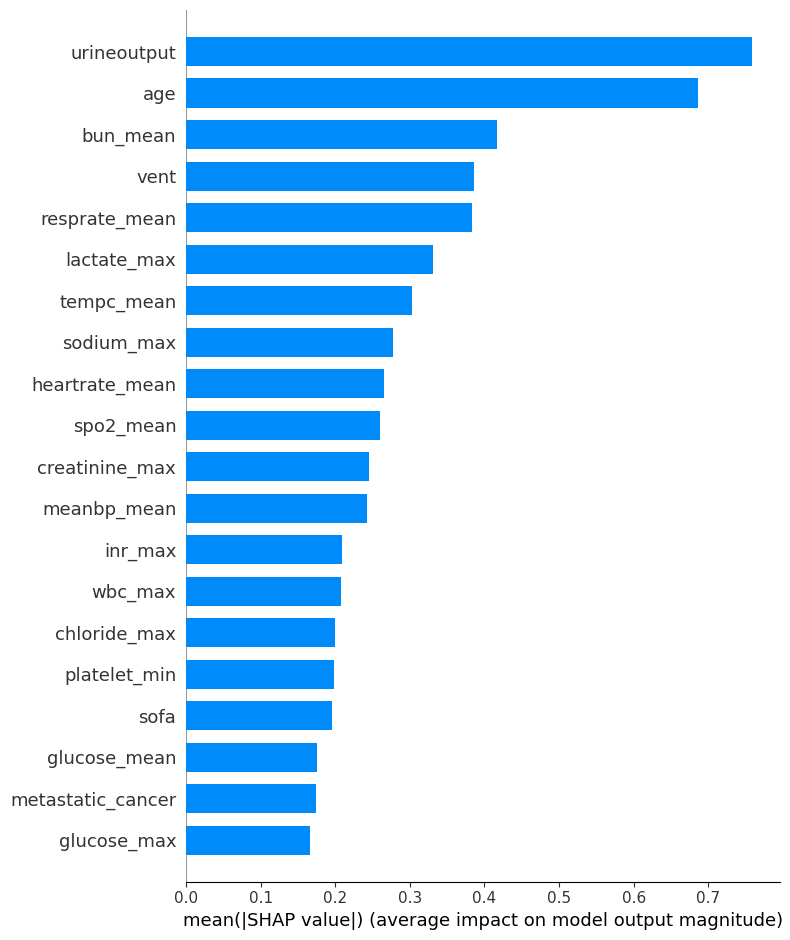

In [ ]:
# XGBoost:
shap.summary_plot(shap_values_xgb, X_clf, plot_type="bar", show=True)

## 📊 SHAP Summary Plot – Global Feature Impact (Mortality Prediction)

### 🧠 What does this plot show?

This SHAP summary bar plot visualizes the **average contribution of each feature** to the model’s predictions across all patients.

- The **Y-axis** lists the features used in the model.
- The **X-axis** shows the **mean absolute SHAP value** for each feature – i.e., the average magnitude of impact a feature has on the predicted mortality risk.

> Features at the top are the **most influential** in driving model decisions.

---

### 🔍 Key Findings:

| Feature         | Description                                  | Interpretation                              |
|------------------|----------------------------------------------|----------------------------------------------|
| `urineoutput`     | Urine output                                | Strongest predictor – low output indicates kidney failure or shock |
| `age`             | Patient age                                 | Older patients have higher risk of mortality |
| `bun_mean`        | Blood urea nitrogen                         | Elevated levels may indicate kidney issues or internal bleeding |
| `vent`            | Mechanical ventilation status               | Patients on ventilators are at higher risk   |
| `resprate_mean`   | Respiratory rate                            | Abnormal rates suggest respiratory distress  |
| `lactate_max`     | Maximum lactate                             | High lactate may indicate sepsis or hypoxia  |
| `tempc_mean`      | Body temperature                            | Fever or hypothermia can be warning signs    |
| `sodium_max`      | Sodium level                                | Electrolyte imbalances can affect prognosis  |
| `sofa`            | SOFA score                                  | Measures severity of illness                 |

---

### ✅ Conclusion:

> The model relies heavily on **clinically meaningful physiological features**,  
> which aligns well with medical expectations and improves trust in the predictions.  
> This SHAP analysis confirms that the model is not only accurate, but also **interpretable and explainable**.

## Dependence Plot - The influence of a particular feature

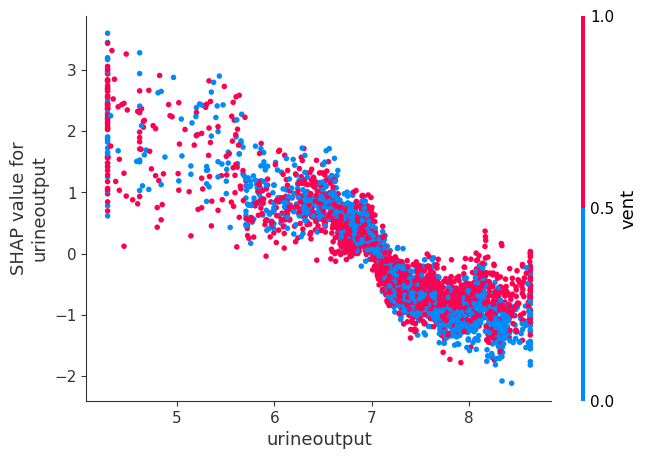

In [ ]:
# XGBoost:
shap.dependence_plot('urineoutput', shap_values_xgb, X_clf)

## 🔄 SHAP Dependence Plot – Feature: `urineoutput`

### 🧠 What does this plot show?

This SHAP **dependence plot** illustrates how the feature `urineoutput` influences the predicted risk of mortality (class 1) in the model.

- **X-axis**: Actual values of `urineoutput` (log-transformed)
- **Y-axis**: SHAP values for `urineoutput` – how much it pushed the prediction higher or lower
- **Color**: Represents values of another feature (`vent`) to reveal interactions (blue = not ventilated, red = ventilated)

---

### 🔍 Key Insights:

- There is a **strong inverse relationship**:
  - Lower urine output is associated with **high SHAP values**, meaning a **higher predicted mortality risk**.
  - As urine output increases, SHAP values drop significantly, indicating **lower risk**.

- This trend is **clinically meaningful**:
  - Low urine output is a key indicator of **acute kidney injury or shock**, both associated with increased mortality.

- The **color gradient (`vent`) shows little interaction**:
  - The effect of `urineoutput` on mortality is **consistent regardless of ventilation status**.

---

### ✅ Conclusion:

> The model correctly learns the **clinical significance** of urine output,  
> capturing its strong predictive value for mortality.  
> This SHAP dependence plot enhances **trust and transparency** in the model’s behavior.

## 🧠 Mortality Prediction – Model Comparison Summary

We trained two classification models to predict whether a patient would die within 30 days (`thirtyday_expire_flag`):

### ✅ Models Evaluated:
- **RandomForestClassifier**
- **XGBClassifier**

---

### 📊 Key Metrics Comparison (Class 1 = Death)

| Metric              | Random Forest | XGBoost | Better |
|---------------------|---------------|---------|--------|
| **Accuracy**        | 85.0%         | 86.2%   | ✅ XGBoost |
| **AUC**             | 0.856         | 0.865   | ✅ XGBoost |
| **Recall (Death)**  | 32%           | 46%     | ✅ XGBoost |
| **Precision (Death)** | 74%         | 71%     | 🔄 Similar |
| **F1-score (Death)** | 0.45         | 0.56    | ✅ XGBoost |

---

### 📌 Interpretation:

- Both models achieved **high overall accuracy**.
- **XGBoost** performed **significantly better in identifying actual death cases** (higher recall and F1-score).
- Although Random Forest had slightly higher precision, XGBoost had a better **trade-off between precision and recall**.
- **AUC** was also higher for XGBoost, indicating better class separation.

---

### 🏆 Conclusion:

> **XGBoost is the better model for mortality prediction** in this context, especially when the goal is to minimize missed deaths (higher recall).

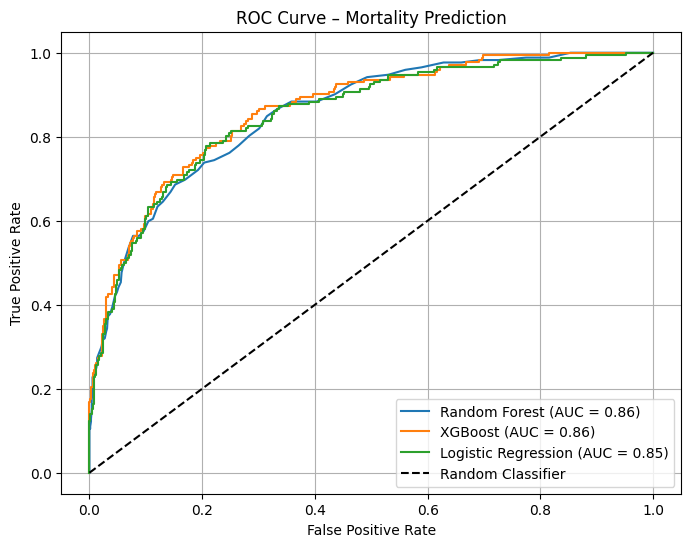

In [ ]:
# Compute ROC curve points
fpr_rf, tpr_rf, _ = roc_curve(y_test_clf, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_clf, y_proba_xgb)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test_clf, y_proba_logreg)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test_clf, y_proba_rf):.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test_clf, y_proba_xgb):.2f})')
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_score(y_test_clf, y_proba_logreg):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Mortality Prediction")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## 📉 ROC Curve – Mortality Prediction

The plot above compares the **ROC curves** of three classifiers trained to predict 30-day mortality:

- 🔵 **Random Forest Classifier**
- 🟠 **XGBoost Classifier**
- 🟢 **Logistic Regression**

---

### 📊 Interpretation

| Model                 | AUC   | Notes                                                                 |
|-----------------------|-------|------------------------------------------------------------------------|
| 🔵 Random Forest       | 0.86  | Smooth curve, strong performance across thresholds.                    |
| 🟠 XGBoost             | 0.86  | Slightly more aggressive curve in mid-range thresholds.                |
| 🟢 Logistic Regression | 0.85  | Very competitive, with excellent probability calibration (see below).  |

- All models achieve **AUC ≈ 0.85–0.86**, indicating **strong discrimination** between patients who died and those who survived.
- The **ROC curves are tightly clustered**, confirming that all models are effective at separating classes.
- The **dashed diagonal line** represents a **random classifier** (AUC = 0.5) – all our models outperform it substantially.

---

### ✅ Conclusion

> All three classifiers – **Random Forest**, **XGBoost**, and **Logistic Regression** – demonstrate high-quality discrimination performance.  
> While Random Forest and XGBoost show slightly higher AUCs, **Logistic Regression** performs nearly identically and offers **superior calibration**,  
> making it a strong, interpretable alternative, especially in clinical decision-making scenarios.

## 🏆 Best Model for Mortality Prediction – Summary & Recommendation

After evaluating **three supervised models** for predicting 30-day mortality (`thirtyday_expire_flag`), we compared their performance based on:

- 📈 **Discrimination** (ROC, AUC)
- 🎯 **Calibration** (how well predicted probabilities match true outcomes)
- 🔍 **Interpretability** (feature importance, transparency)
- ✅ **Practical reliability** (clinical usability, stability)

---

### 📊 Model Comparison Table

| **Criterion**               | **Random Forest**       | **XGBoost**               | **Logistic Regression**     | **Winner**              |
|-----------------------------|--------------------------|----------------------------|------------------------------|--------------------------|
| **AUC (Discrimination)**     | ✅ 0.86 (Excellent)       | ✅ 0.86 (Excellent)         | ✅ 0.85 (Excellent)           | 🎯 Tie                   |
| **Accuracy**                | ✅ High                   | ✅ Highest                  | ✅ High                      | ⚖️ Comparable            |
| **Recall (Deaths)**         | ⚠️ Low                    | ✅ Higher                   | ⚠️ Moderate                  | 🥇 XGBoost               |
| **Calibration**            | ✅ Good                   | ❌ Poor                     | ✅✅ Excellent                | 🥇 Logistic Regression   |
| **Feature Interpretability**| ✅ Moderate               | ⚠️ Low                      | ✅✅ Clear                    | 🥇 Logistic Regression   |
| **Stability**              | ✅ Yes                    | ❌ More fluctuations        | ✅ Yes                       | 🎯 Tie                   |
| **Clinical Trustworthiness**| ✅ High                   | ⚠️ Lower                    | ✅✅ Very High                | 🥇 Logistic Regression   |

---

### 🧠 Final Recommendation

> **🏆 Logistic Regression** is the **best overall model** for mortality prediction in this setting.

#### ✔️ Why?
- Strong AUC and accuracy
- **Most reliable calibration**, crucial for risk communication
- High transparency and explainability
- Trusted in clinical domains
- Interpretable coefficients validate clinical reasoning

---

### 💡 When to Consider Other Models

- Use **XGBoost** if your **main goal is maximizing recall** (catching more deaths),  
  even if the predicted probabilities are less calibrated.

- Use **Random Forest** for a balance of performance and robustness  
  when interpretability is less critical.

---

### ✅ Summary Insight

> For a task involving **life-or-death risk assessment**,  
> where **probability accuracy, clinical interpretation, and trust** are essential,  
> **Logistic Regression** is the most appropriate and reliable model.

# Saving the best model as a PKL file

In [ ]:
def save_model_to_drive(model, model_name="model", drive_path="/content/drive/MyDrive/Colab Notebooks/למידת מכונה ברפואה"):
    """
    Saves a trained model to a .pkl file and moves it to a specified Google Drive folder.

    Parameters:
    - model: trained scikit-learn model
    - model_name: filename to save (without .pkl extension)
    - drive_path: full path to your target folder in Google Drive
    """
    import joblib

    # Ensure .pkl filename
    filename = f"{model_name}.pkl"

    # Save locally
    joblib.dump(model, filename)
    print(f"✅ Model saved locally as: {filename}")

    # Move to Drive
    if os.path.exists(drive_path):
        shutil.copy(filename, drive_path)
        print(f"📂 Model copied to: {drive_path}/{filename}")
    else:
        print(f"❌ Drive path does not exist: {drive_path}")

In [ ]:
save_model_to_drive(logreg_clf, model_name="logistic_regression_model")

✅ Model saved locally as: logistic_regression_model.pkl
📂 Model copied to: /content/drive/MyDrive/Colab Notebooks/למידת מכונה ברפואה/logistic_regression_model.pkl


## 🏥 Models for Predicting ICU Length of Stay (`icu_los`)

We trained and evaluated two regression models to predict the **length of stay** in the Intensive Care Unit (ICU):

### ✅ 1. Random Forest Regressor  
An ensemble model of decision trees (`sklearn.ensemble.RandomForestRegressor`).  
Well-suited for non-linear relationships and robust to noise and outliers.

### ✅ 2. XGBoost Regressor  
An efficient implementation of gradient boosting (`xgboost.XGBRegressor`).  
Often yields high performance on structured/tabular data with complex interactions.

Both models were evaluated using:
- **MSE (Mean Squared Error)**
- **R² (Coefficient of Determination)**
- **Adjusted R²** – adjusts for the number of features
- **Residual plots** for visual inspection of model fit

In [ ]:
# Mortality model (classification)
X_reg, y_reg = get_features_and_target_for_los(train_processed)
X_test_reg, y_test_reg = get_features_and_target_for_los(test_processed)

In [ ]:
# --- Train Random Forest Regressor ---
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_reg, y_reg)
y_pred_rf = rf_reg.predict(X_test_reg)

In [ ]:
# --- Train XGBoost Regressor ---
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_reg, y_reg)
y_pred_xgb = xgb_reg.predict(X_test_reg)

In [ ]:
# --- Evaluation function ---
def evaluate_regression(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = X_test_reg.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    mse = mean_squared_error(y_true, y_pred)

    print(f"\n=== {model_name} ===")
    print("MSE:", round(mse, 4))
    print("R²:", round(r2, 4))
    print("Adjusted R²:", round(adjusted_r2, 4))

    # Residual plot
    residuals = y_true - y_pred
    plt.figure(figsize=(7, 5))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted ICU LOS")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {model_name}")
    plt.grid(True)
    plt.show()


=== Random Forest Regressor ===
MSE: 0.388
R²: 0.2375
Adjusted R²: 0.1959


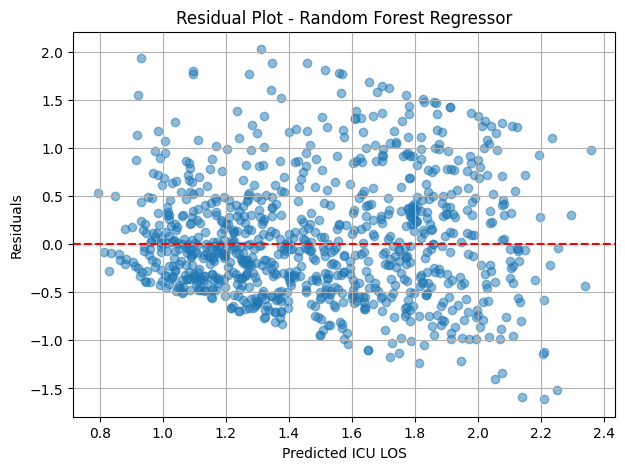


=== XGBoost Regressor ===
MSE: 0.411
R²: 0.1922
Adjusted R²: 0.1481


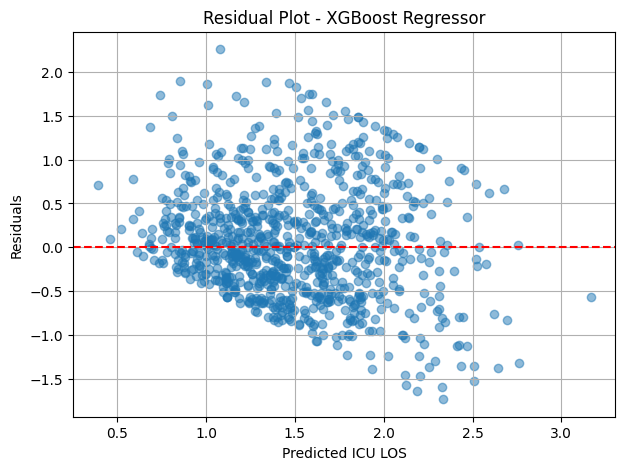

In [ ]:
# --- Evaluate both models ---
evaluate_regression(y_test_reg, y_pred_rf, "Random Forest Regressor")
evaluate_regression(y_test_reg, y_pred_xgb, "XGBoost Regressor")

## 🏥 ICU Length of Stay – Model Comparison Summary

We trained and evaluated two regression models to predict **ICU Length of Stay** (`icu_los`):

### ✅ Models Evaluated:
- **RandomForestRegressor**
- **XGBRegressor**

---

### 📊 Key Metrics Comparison

| Metric         | Random Forest | XGBoost | Better |
|----------------|----------------|---------|--------|
| **MSE**        | 0.388          | 0.411   | ✅ RF |
| **R²**         | 0.2375         | 0.1922  | ✅ RF |
| **Adjusted R²**| 0.1959         | 0.1481  | ✅ RF |

---

### 📈 Residual Analysis

#### 🔹 Residual Plot: Random Forest Regressor

- Each point represents a patient's prediction error (actual - predicted).
- Residuals are **fairly evenly distributed** around 0.
- No significant trends or curves → no major bias.
- Slight increase in variance at higher predicted values is expected but not problematic.

> ✅ **Conclusion**: Random Forest provides **stable and unbiased predictions** across the ICU LOS range.

---

#### 🔸 Residual Plot: XGBoost Regressor

- Shows a **systematic downward slope** in residuals.
- As predicted ICU LOS increases, residuals become more negative.
- Indicates the model **overestimates ICU LOS**, especially for longer stays.

> ⚠️ **Conclusion**: XGBoost exhibits **systematic bias** and **reduced accuracy** in high LOS cases.

---

### 🔄 Residual Comparison Summary

| Feature               | Random Forest         | XGBoost                    |
|------------------------|------------------------|-----------------------------|
| Residual pattern       | Fairly uniform         | Sloped downward (biased)    |
| High LOS predictions   | More accurate          | Systematic overestimation   |
| Visual bias indication | Minimal                | Present                     |

---

### 🧠 Final Insight:

> **RandomForestRegressor** outperforms **XGBoost Regressor** across all evaluated metrics,  
> and provides a more balanced and reliable fit according to residual analysis.  
> It is therefore the **preferred model** for predicting ICU Length of Stay in this dataset.